#### Machine Learning

In [25]:
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, cross_val_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [26]:
#df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")
#df = pd.read_csv("../../data/exosomes.raw_spectrum_380-1800.csv")
#df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")
df = pd.read_csv("../../data/current_clean_spectrum.csv")

In [27]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531


In [28]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    # Include the SurID to perform GroupKFold CV
    statuses_and_surface = df[['SpecID', 'SurID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses_and_surface, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

In [29]:
def evaluate_extra_trees(df):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using GroupKFold for classification tasks
    cv = GroupKFold(n_splits=10)
    
    # Getting cross-validation scores
    scores = cross_val_score(et, X, y, cv=cv, scoring='accuracy',groups=groups)
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

In [30]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [31]:
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,41.863303,41.803843,41.741884,41.677722,41.611654,41.543974,41.474980,41.404968,41.334234,41.263073,...,6.280946,5.549559,4.745724,3.866578,2.909255,1.870891,0.748623,-0.460415,201210-1,Normal
201210-1-01,46.314608,47.323684,48.299209,49.241395,50.150457,51.026608,51.870063,52.681035,53.459738,54.206386,...,6.769011,7.280928,7.861246,8.512936,9.238972,10.042323,10.925962,11.892860,201210-1,Normal
201210-1-02,118.159018,114.686240,111.563911,108.777452,106.312282,104.153823,102.287493,100.698715,99.372907,98.295491,...,-4.633601,-4.557349,-4.439365,-4.278894,-4.075180,-3.827470,-3.535010,-3.197043,201210-1,Normal
201210-1-03,175.466997,174.846086,174.188020,173.498226,172.782129,172.045155,171.292728,170.530275,169.763222,168.996993,...,-10.801936,-10.349539,-9.864191,-9.347124,-8.799567,-8.222752,-7.617909,-6.986269,201210-1,Normal
201210-1-04,111.814973,106.629998,101.867380,97.512673,93.551430,89.969205,86.751551,83.884023,81.352173,79.141556,...,-11.689508,-11.752441,-11.789205,-11.799583,-11.783357,-11.740310,-11.670224,-11.572882,201210-1,Normal


Show the performance of the current approach.

In [32]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.6123 +/- 0.1083


Fit an Extra Trees Classifier on the whole dataset.

In [33]:
# Splitting the dataframe into features (X) and target variable (y)
X = wavelength_df.drop(['Status', 'SurID'], axis=1)
y = wavelength_df['Status']

et = ExtraTreesClassifier(random_state=1234)
et.fit(X, y)

ExtraTreesClassifier(random_state=1234)

In [34]:
feature_names = X.columns
importances = et.feature_importances_

# Creating a DataFrame from the feature names and importance
wavenumber_importance_df = pd.DataFrame({
    'WaveNumber': feature_names,
    'Importance': importances
})

wavenumber_importance_df

,WaveNumber,Importance
0,400.22778,0.000435
1,400.91116,0.000829
2,401.59454,0.000708
3,402.27789,0.000874
4,402.96127,0.000341
...,...,...
2044,1797.0387,0.000380
2045,1797.722,0.000174
2046,1798.4055,0.000218
2047,1799.0889,0.000131


In [35]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,293,400.22778,201210-1,Normal,41.863303
1,201210-1-00,294,400.91116,201210-1,Normal,41.803843
2,201210-1-00,295,401.59454,201210-1,Normal,41.741884
3,201210-1-00,296,402.27789,201210-1,Normal,41.677722
4,201210-1-00,297,402.96127,201210-1,Normal,41.611654
...,...,...,...,...,...,...
6239200,210526-3-09,2337,1797.03870,210526-3,Hyperglycemia,12.378163
6239201,210526-3-09,2338,1797.72200,210526-3,Hyperglycemia,13.269937
6239202,210526-3-09,2339,1798.40550,210526-3,Hyperglycemia,14.199285
6239203,210526-3-09,2340,1799.08890,210526-3,Hyperglycemia,15.166531


Seaborn was using different axes so I used Matplotlib instead.

Text(0.5, 1.0, 'Feature Importance and Average Spectra of each Status')

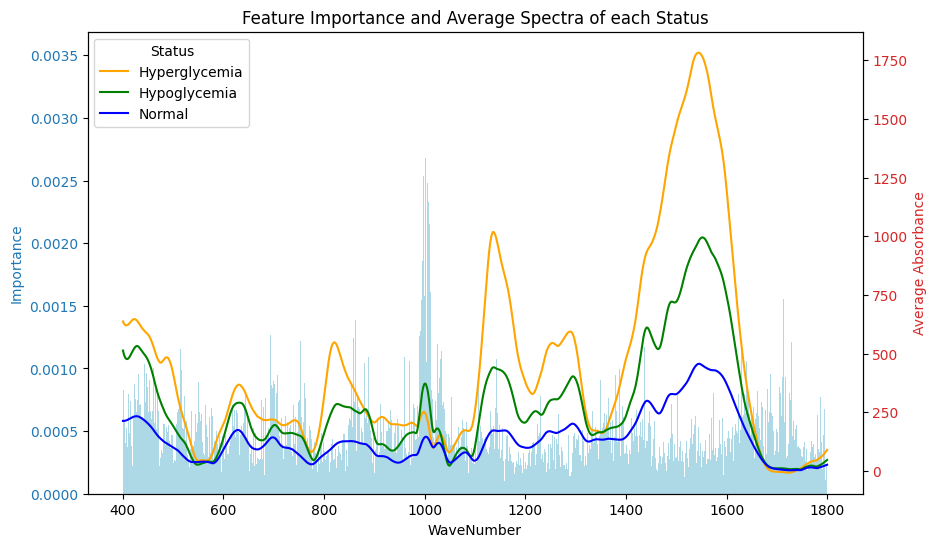

In [36]:
# Create the figure and the first (left) axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar plot on the first axis for Feature Importance
colors = ['lightblue'] * len(wavenumber_importance_df['WaveNumber'])
ax1.bar(wavenumber_importance_df['WaveNumber'], wavenumber_importance_df['Importance'], color=colors)
ax1.set_xlabel('WaveNumber')
ax1.set_ylabel('Importance', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second (right) axis, sharing the same x-axis
ax2 = ax1.twinx()

# Calculate average absorbance by WaveNumber and Status
avg_absorbance = df.groupby(['WaveNumber', 'Status'])['Absorbance'].mean().reset_index()

# Color mapping for 'Status'
color_map = {'Normal': 'blue', 'Hyperglycemia': 'orange', 'Hypoglycemia': 'green'}

# Plot average absorbance line plot on the second axis for each status
for status, group in avg_absorbance.groupby('Status'):
    ax2.plot(group['WaveNumber'], group['Absorbance'], label=status, color=color_map[status])

ax2.set_ylabel('Average Absorbance', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legend for the line plots to distinguish between statuses
ax2.legend(title='Status')

# Title for the entire plot
plt.title('Feature Importance and Average Spectra of each Status')

# # Show the plot
# plt.tight_layout()
# plt.show()

#### **Cross-Val Importance**

Training the model on the whole dataset may be misleading, lets look at the average feature importance of each WaveNumber across the 10 folds.

In [37]:
groups = wavelength_df['SurID']
X = wavelength_df.drop(['Status', 'SurID'], axis=1)
y = wavelength_df['Status']

# Creating the Extra Trees classifier
et = ExtraTreesClassifier(random_state=1234)

# Using GroupKFold for classification tasks
cv = GroupKFold(n_splits=10)

# Initialising an array to store feature importances across all folds
feature_importances = np.zeros(X.shape[1])

# Looping through each split, correctly using the groups
for train_index, test_index in cv.split(X, y, groups=groups):
    
    # Splitting the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fitting the Extra Trees classifier
    et.fit(X_train, y_train)
    
    # Accumulating the feature importances
    feature_importances += et.feature_importances_

# Averaging the feature importances across all folds
feature_importances /= cv.get_n_splits()

# Creating a DataFrame from the feature names and their average importance
feature_names = X.columns
wavenumber_importance_df = pd.DataFrame({
    'WaveNumber': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

wavenumber_importance_df

,WaveNumber,Importance
873,996.81091,0.002577
876,998.86102,0.002527
880,1001.5945,0.002301
882,1002.9613,0.002296
870,994.7608,0.002290
...,...,...
1175,1203.1891,0.000202
1287,1279.7267,0.000201
1177,1204.5558,0.000196
1149,1185.4214,0.000194


Text(0.5, 1.0, 'Feature Importance and Average Spectra of each Status')

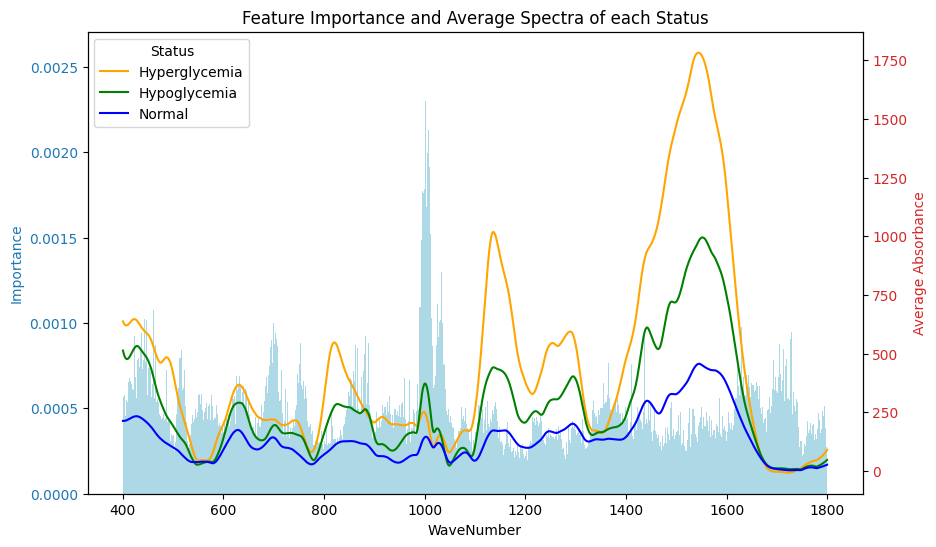

In [38]:
# Create the figure and the first (left) axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar plot on the first axis for Feature Importance
colors = ['lightblue'] * len(wavenumber_importance_df['WaveNumber'])
ax1.bar(wavenumber_importance_df['WaveNumber'], wavenumber_importance_df['Importance'], color=colors)
ax1.set_xlabel('WaveNumber')
ax1.set_ylabel('Importance', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second (right) axis, sharing the same x-axis
ax2 = ax1.twinx()

# Calculate average absorbance by WaveNumber and Status
avg_absorbance = df.groupby(['WaveNumber', 'Status'])['Absorbance'].mean().reset_index()

# Color mapping for 'Status'
color_map = {'Normal': 'blue', 'Hyperglycemia': 'orange', 'Hypoglycemia': 'green'}

# Plot average absorbance line plot on the second axis for each status
for status, group in avg_absorbance.groupby('Status'):
    ax2.plot(group['WaveNumber'], group['Absorbance'], label=status, color=color_map[status])

ax2.set_ylabel('Average Absorbance', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legend for the line plots to distinguish between statuses
ax2.legend(title='Status')

# Title for the entire plot
plt.title('Feature Importance and Average Spectra of each Status')

# # Show the plot
# plt.tight_layout()
# plt.show()

##### **Feature Selection Based on Importance**

In [39]:
wavenumber_importance_df

,WaveNumber,Importance
873,996.81091,0.002577
876,998.86102,0.002527
880,1001.5945,0.002301
882,1002.9613,0.002296
870,994.7608,0.002290
...,...,...
1175,1203.1891,0.000202
1287,1279.7267,0.000201
1177,1204.5558,0.000196
1149,1185.4214,0.000194


In [65]:
def evaluate_features(df, threshold_range=np.arange(0, 0.0025, 0.00005)):

    # Set the Surfaces as groups
    groups = df['SurID']
    X = df.drop(['Status', 'SurID'], axis=1)
    y = df['Status']

    # Initialise arrays to store results
    thresholds = []
    mean_accuracies = []
    std_accuracies = []

    # Loop over the threshold range
    for threshold in threshold_range:
        selected_features = wavenumber_importance_df[wavenumber_importance_df['Importance'] > threshold]['WaveNumber'].tolist()
        X_selected = X[selected_features]
        
        # Creating the Extra Trees classifier
        et = ExtraTreesClassifier(random_state=1234)

        # Using GroupKFold for classification tasks
        cv = GroupKFold(n_splits=10)

        # Getting cross-validation scores
        scores = cross_val_score(et, X_selected, y, cv=cv, scoring='accuracy', groups=groups, n_jobs=-1)
        
        # Storing results
        thresholds.append(threshold)
        mean_accuracies.append(np.mean(scores))
        std_accuracies.append(np.std(scores))

    # Displaying the results
    results_df = pd.DataFrame({
        'Threshold': thresholds,
        'Mean Accuracy': mean_accuracies,
        'Std Accuracy': std_accuracies
    })
    print(results_df)

    # Plotting mean accuracy vs threshold
    plt.figure(figsize=(15, 6))
    plt.errorbar(thresholds, mean_accuracies, yerr=std_accuracies, fmt='-o')
    plt.xlabel('Threshold')
    plt.ylabel('Mean Accuracy')
    plt.title('Mean Accuracy vs Threshold')
    plt.show()

    return results_df

    Threshold  Mean Accuracy  Std Accuracy
0     0.00000       0.604111      0.113257
1     0.00005       0.604111      0.113257
2     0.00010       0.604111      0.113257
3     0.00015       0.604111      0.113257
4     0.00020       0.603048      0.102440
5     0.00025       0.602667      0.102612
6     0.00030       0.608111      0.100724
7     0.00035       0.607095      0.107264
8     0.00040       0.604619      0.101915
9     0.00045       0.609413      0.091733
10    0.00050       0.609429      0.086215
11    0.00055       0.590222      0.094481
12    0.00060       0.583365      0.092091
13    0.00065       0.577556      0.092734
14    0.00070       0.578571      0.094244
15    0.00075       0.571460      0.101410
16    0.00080       0.572016      0.087684
17    0.00085       0.573889      0.089297
18    0.00090       0.573603      0.087581
19    0.00095       0.558429      0.086372
20    0.00100       0.559873      0.088458
21    0.00105       0.527063      0.093362
22    0.001

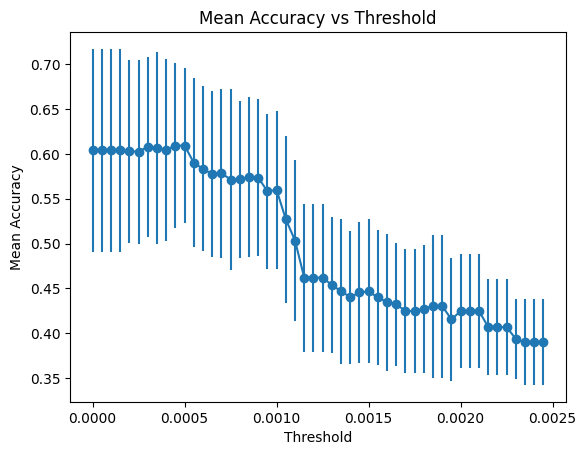

In [58]:
evaluate_features(wavelength_df)

    Threshold  Mean Accuracy  Std Accuracy
0     0.00000       0.604111      0.113257
1     0.00001       0.604111      0.113257
2     0.00002       0.604111      0.113257
3     0.00003       0.604111      0.113257
4     0.00004       0.604111      0.113257
5     0.00005       0.604111      0.113257
6     0.00006       0.604111      0.113257
7     0.00007       0.604111      0.113257
8     0.00008       0.604111      0.113257
9     0.00009       0.604111      0.113257
10    0.00010       0.604111      0.113257
11    0.00011       0.604111      0.113257
12    0.00012       0.604111      0.113257
13    0.00013       0.604111      0.113257
14    0.00014       0.604111      0.113257
15    0.00015       0.604111      0.113257
16    0.00016       0.604111      0.113257
17    0.00017       0.604111      0.113257
18    0.00018       0.604111      0.113257
19    0.00019       0.609063      0.117947
20    0.00020       0.603048      0.102440
21    0.00021       0.602159      0.105767
22    0.000

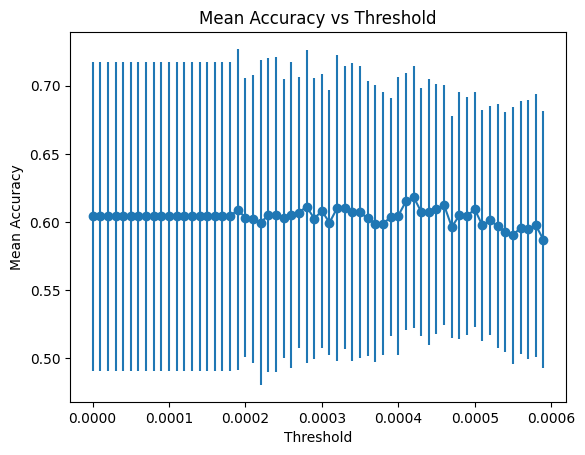

In [62]:
evaluate_features(wavelength_df, threshold_range=np.arange(0, 0.0006, 0.00001))

     Threshold  Mean Accuracy  Std Accuracy
0     0.000250       0.602667      0.102612
1     0.000251       0.602984      0.107762
2     0.000252       0.601365      0.110578
3     0.000253       0.600984      0.103395
4     0.000254       0.601571      0.113417
..         ...            ...           ...
345   0.000595       0.582937      0.099172
346   0.000596       0.585714      0.084260
347   0.000597       0.582667      0.094339
348   0.000598       0.583667      0.094505
349   0.000599       0.588159      0.090415

[350 rows x 3 columns]


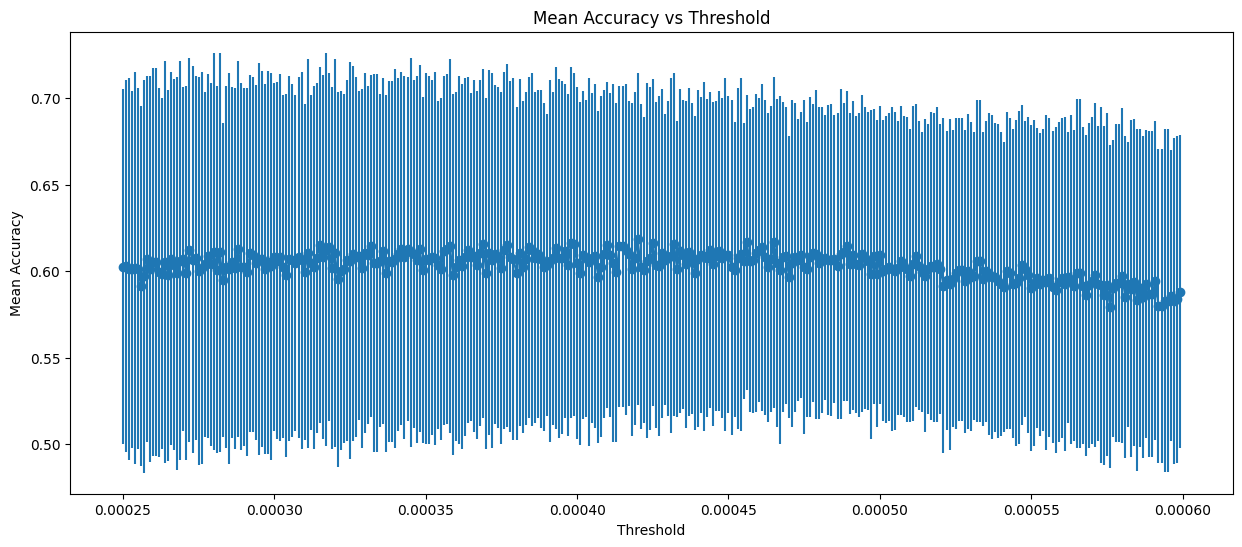

In [66]:
feature_thresholds = evaluate_features(wavelength_df, threshold_range=np.arange(0.00025, 0.0006, 0.000001))

In [72]:
pd.options.display.max_rows = 100
feature_thresholds.sort_values('Mean Accuracy', ascending=False)

,Threshold,Mean Accuracy,Std Accuracy
170,0.000420,0.618397,0.095962
215,0.000465,0.616619,0.095737
206,0.000456,0.616603,0.085171
175,0.000425,0.616444,0.094728
148,0.000398,0.616429,0.101605
...,...,...,...
345,0.000595,0.582937,0.099172
347,0.000597,0.582667,0.094339
342,0.000592,0.580032,0.090869
343,0.000593,0.580032,0.090869


     Threshold  Mean Accuracy  Std Accuracy
0     0.000410       0.615127      0.094357
1     0.000410       0.615127      0.094357
2     0.000410       0.602032      0.094094
3     0.000410       0.602032      0.094094
4     0.000410       0.602032      0.094094
..         ...            ...           ...
145   0.000425       0.605825      0.102780
146   0.000425       0.605825      0.102780
147   0.000425       0.605825      0.102780
148   0.000425       0.605825      0.102780
149   0.000425       0.616444      0.094728

[150 rows x 3 columns]


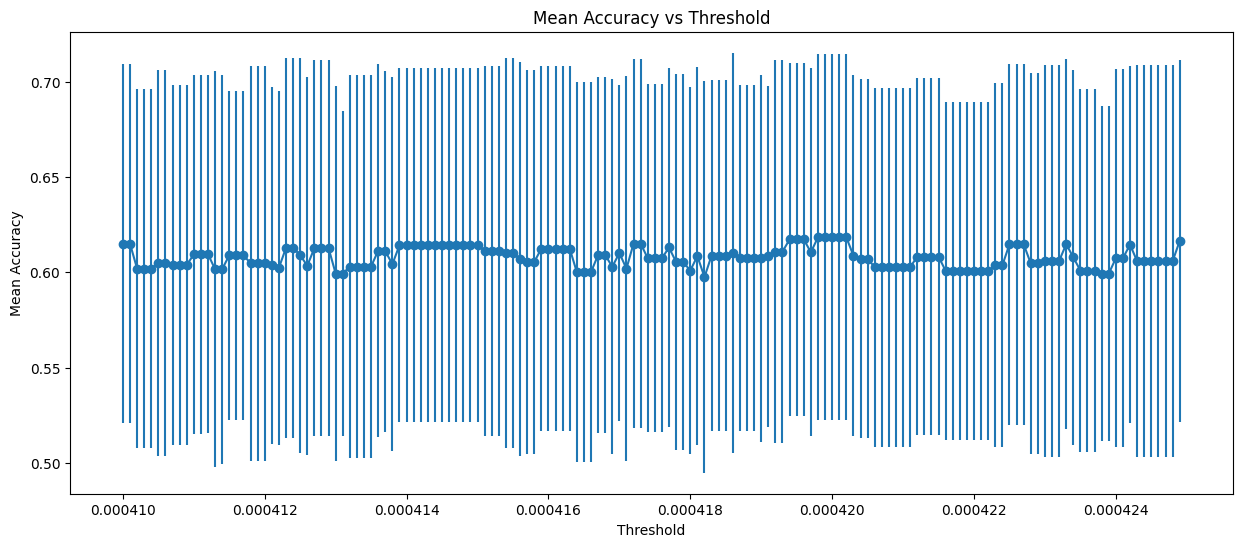

In [76]:
feature_thresholds = evaluate_features(wavelength_df, threshold_range=np.arange(0.00041, 0.000425, 0.0000001))

In [77]:
feature_thresholds.sort_values('Mean Accuracy', ascending=False)

,Threshold,Mean Accuracy,Std Accuracy
102,0.000420,0.618397,0.095962
101,0.000420,0.618397,0.095962
100,0.000420,0.618397,0.095962
99,0.000420,0.618397,0.095962
98,0.000420,0.618397,0.095962
...,...,...,...
30,0.000413,0.599381,0.098169
139,0.000424,0.599333,0.087844
138,0.000424,0.599333,0.087844
31,0.000413,0.599302,0.085311


In [79]:
selected_features = wavenumber_importance_df[wavenumber_importance_df['Importance'] > 0.000420]
selected_features

,WaveNumber,Importance
873,996.81091,0.002577
876,998.86102,0.002527
880,1001.5945,0.002301
882,1002.9613,0.002296
870,994.7608,0.002290
...,...,...
1995,1763.5536,0.000421
652,845.78589,0.000421
1603,1495.672,0.000420
1194,1216.1731,0.000420


Text(0.5, 1.0, 'Feature Importance and Average Spectra of each Status')

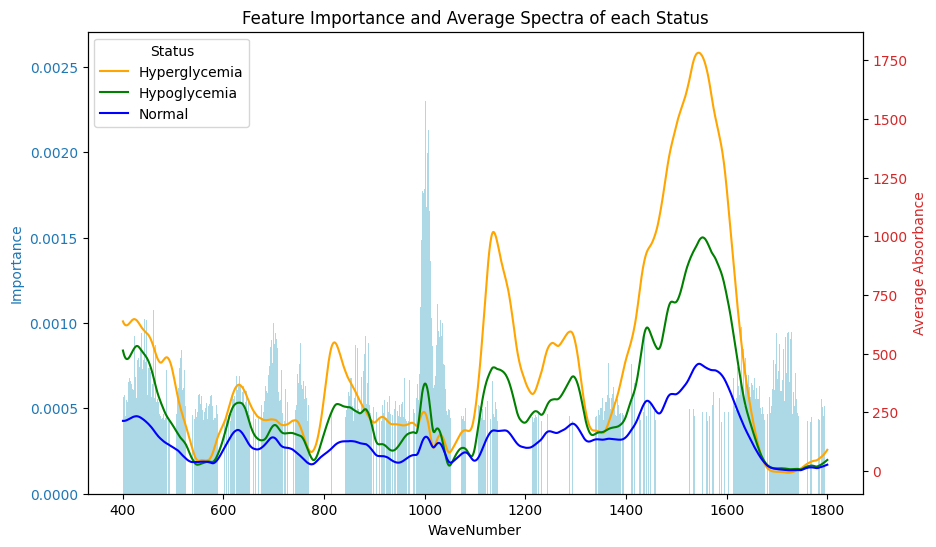

In [80]:
# Create the figure and the first (left) axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar plot on the first axis for Feature Importance
colors = ['lightblue'] * len(wavenumber_importance_df['WaveNumber'])
ax1.bar(selected_features['WaveNumber'], selected_features['Importance'], color=colors)
ax1.set_xlabel('WaveNumber')
ax1.set_ylabel('Importance', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create the second (right) axis, sharing the same x-axis
ax2 = ax1.twinx()

# Calculate average absorbance by WaveNumber and Status
avg_absorbance = df.groupby(['WaveNumber', 'Status'])['Absorbance'].mean().reset_index()

# Color mapping for 'Status'
color_map = {'Normal': 'blue', 'Hyperglycemia': 'orange', 'Hypoglycemia': 'green'}

# Plot average absorbance line plot on the second axis for each status
for status, group in avg_absorbance.groupby('Status'):
    ax2.plot(group['WaveNumber'], group['Absorbance'], label=status, color=color_map[status])

ax2.set_ylabel('Average Absorbance', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Adding legend for the line plots to distinguish between statuses
ax2.legend(title='Status')

# Title for the entire plot
plt.title('Feature Importance and Average Spectra of each Status')

# # Show the plot
# plt.tight_layout()
# plt.show()